# Reranking Methods in RAG Systems



# Package Installation and Imports


In [34]:
!pip install -q langchain-huggingface tools fitz langchain==1.0.5 langchain-community langchain-core langchain-openai sentence-transformers faiss-cpu pypdf tiktoken python-dotenv rank_bm25

In [3]:
# Clone the repository to access helper functions and evaluation modules
!git clone https://github.com/NirDiamant/RAG_TECHNIQUES.git
import sys
sys.path.append('RAG_TECHNIQUES')
# If you need to run with the latest data
# !cp -r RAG_TECHNIQUES/data .

Cloning into 'RAG_TECHNIQUES'...
remote: Enumerating objects: 1769, done.
remote: Counting objects: 100% (1105/1105), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 1769 (delta 735), reused 690 (delta 688), pack-reused 664 (from 4)
Receiving objects: 100% (1769/1769), 36.51 MiB | 26.46 MiB/s, done.
Resolving deltas: 100% (1121/1121), done.


In [32]:
import os
import sys
from dotenv import load_dotenv
from typing import List, Dict, Any, Tuple

from langchain_core.documents import Document

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_classic.chains import RetrievalQA
from langchain_core.retrievers import BaseRetriever
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_community.vectorstores import FAISS

# Sentence Transformers
from sentence_transformers import CrossEncoder
from helper_functions import replace_t_with_space
# from evaluation.evalute_rag import *

from google.colab import userdata
# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')

### Define the document's path

In [25]:
# Download required data files
import os
os.makedirs('data', exist_ok=True)

# Download the PDF document used in this notebook
!wget -O data/Understanding_Climate_Change.pdf https://raw.githubusercontent.com/NirDiamant/RAG_TECHNIQUES/main/data/Understanding_Climate_Change.pdf
!wget -O data/Understanding_Climate_Change.pdf https://raw.githubusercontent.com/NirDiamant/RAG_TECHNIQUES/main/data/Understanding_Climate_Change.pdf


--2026-01-26 18:51:25--  https://raw.githubusercontent.com/NirDiamant/RAG_TECHNIQUES/main/data/Understanding_Climate_Change.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206372 (202K) [application/octet-stream]
Saving to: ‘data/Understanding_Climate_Change.pdf’

data/Understanding_ 100%[===================>] 201.54K  --.-KB/s    in 0.02s   

2026-01-26 18:51:25 (7.93 MB/s) - ‘data/Understanding_Climate_Change.pdf’ saved [206372/206372]

--2026-01-26 18:51:25--  https://raw.githubusercontent.com/NirDiamant/RAG_TECHNIQUES/main/data/Understanding_Climate_Change.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

In [26]:
path = "data/Understanding_Climate_Change.pdf"

### Create a vector store
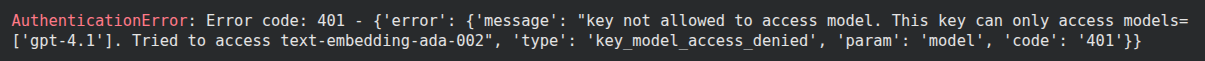

For the reasons mentioned above, I opted for the Hugging Face embedding model over the OpenAI model.

In [36]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
def encode_pdf(path, chunk_size=1000, chunk_overlap=200):
    """
    Encodes a PDF book into a vector store using OpenAI embeddings.

    Args:
        path: The path to the PDF file.
        chunk_size: The desired size of each text chunk.
        chunk_overlap: The amount of overlap between consecutive chunks.

    Returns:
        A FAISS vector store containing the encoded book content.
    """

    # Load PDF documents
    loader = PyPDFLoader(path)
    documents = loader.load()

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    texts = text_splitter.split_documents(documents)
    cleaned_texts = replace_t_with_space(texts)

    # Create embeddings and vector store
    embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    return vectorstore

vectorstore = encode_pdf(path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Method 1: LLM based function to rerank the retrieved documents

### Create a custom reranking function


In [37]:
class RatingScore(BaseModel):
    relevance_score: float = Field(..., description="The relevance score of a document to a query.")

def rerank_documents(query: str, docs: List[Document], top_n: int = 3) -> List[Document]:
    prompt_template = PromptTemplate(
        input_variables=["query", "doc"],
        template="""On a scale of 1-10, rate the relevance of the following document to the query. Consider the specific context and intent of the query, not just keyword matches.
        Query: {query}
        Document: {doc}
        Relevance Score:"""
    )

    llm = ChatOpenAI(temperature=0, model_name="gpt-4.1", max_tokens=4000)
    llm_chain = prompt_template | llm.with_structured_output(RatingScore)

    scored_docs = []
    for doc in docs:
        input_data = {"query": query, "doc": doc.page_content}
        score = llm_chain.invoke(input_data).relevance_score
        try:
            score = float(score)
        except ValueError:
            score = 0  # Default score if parsing fails
        scored_docs.append((doc, score))

    reranked_docs = sorted(scored_docs, key=lambda x: x[1], reverse=True)
    return [doc for doc, _ in reranked_docs[:top_n]]

### Example usage of the reranking function with a sample query relevant to the document


In [38]:
query = "What are the impacts of climate change on biodiversity?"
initial_docs = vectorstore.similarity_search(query, k=15)
reranked_docs = rerank_documents(query, initial_docs)

# print first 3 initial documents
print("Top initial documents:")
for i, doc in enumerate(initial_docs[:3]):
    print(f"\nDocument {i+1}:")
    print(doc.page_content[:200] + "...")  # Print first 200 characters of each document


# Print results
print(f"Query: {query}\n")
print("Top reranked documents:")
for i, doc in enumerate(reranked_docs):
    print(f"\nDocument {i+1}:")
    print(doc.page_content[:200] + "...")  # Print first 200 characters of each document

Top initial documents:

Document 1:
Climate change is altering terrestrial ecosystems by shifting habitat ranges, changing species 
distributions, and impacting ecosystem functions. Forests, grasslands, and deserts are 
experiencing shi...

Document 2:
protection, and habitat creation. 
Climate-Resilient Conservation 
Conservation strategies must account for climate change impacts to be effective. This 
includes identifying climate refugia, areas le...

Document 3:
The economic costs of climate change include damage to infrastructure, reduced agricultural 
productivity, health care costs, and lost labor productivity. Extreme weather events, such as 
hurricanes a...
Query: What are the impacts of climate change on biodiversity?

Top reranked documents:

Document 1:
Climate change is altering terrestrial ecosystems by shifting habitat ranges, changing species 
distributions, and impacting ecosystem functions. Forests, grasslands, and deserts are 
experiencing shi...

Document 2:
Coral re

### Create a custom retriever based on our reranker

In [40]:
# Create a custom retriever class
class CustomRetriever(BaseRetriever, BaseModel):

    vectorstore: Any = Field(description="Vector store for initial retrieval")

    class Config:
        arbitrary_types_allowed = True

    def _get_relevant_documents(self, query: str, num_docs=2) -> List[Document]:
        initial_docs = self.vectorstore.similarity_search(query, k=30)
        return rerank_documents(query, initial_docs, top_n=num_docs)

    async def _aget_relevant_documents(self, query: str, **kwargs) -> List[Document]:
        # Async retrieval is not implemented in this example, but it must be defined
        raise NotImplementedError("Asynchronous retrieval is not implemented.")


# Create the custom retriever
custom_retriever = CustomRetriever(vectorstore=vectorstore)

# Create an LLM for answering questions
llm = ChatOpenAI(temperature=0, model_name="gpt-4.1")

# Create the RetrievalQA chain with the custom retriever
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=custom_retriever,
    return_source_documents=True
)

/tmp/ipython-input-4200024552.py:2: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class CustomRetriever(BaseRetriever, BaseModel):


### Example query


In [41]:
result = qa_chain({"query": query})

print(f"\nQuestion: {query}")
print(f"Answer: {result['result']}")
print("\nRelevant source documents:")
for i, doc in enumerate(result["source_documents"]):
    print(f"\nDocument {i+1}:")
    print(doc.page_content[:200] + "...")  # Print first 200 characters of each document

/tmp/ipython-input-546735038.py:1: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain-classic 0.1.0 and will be removed in 1.0. Use `invoke` instead.
  result = qa_chain({"query": query})



Question: What are the impacts of climate change on biodiversity?
Answer: Climate change has significant impacts on biodiversity, including:

1. **Shifting Habitat Ranges:** As temperatures rise and precipitation patterns change, the suitable habitats for many species move. This forces plants and animals to migrate to new areas, which can lead to local extinctions if they cannot adapt or move.

2. **Changing Species Distributions:** The composition of species in forests, grasslands, deserts, and marine environments is changing. Some species thrive while others decline, disrupting established ecological balances.

3. **Loss of Biodiversity:** These shifts can result in a loss of biodiversity, as some species are unable to survive in new conditions or compete with invasive species that move into their habitats.

4. **Disruption of Ecosystem Functions:** Changes in species composition and abundance can affect ecosystem functions such as pollination, nutrient cycling, and food web dynamic

### Example that demonstrates why we should use reranking

In [45]:
chunks = [
    "The capital of France is great.",
    "The capital of France is huge.",
    "The capital of France is beautiful.",
    """Have you ever visited Paris? It is a beautiful city where you can eat delicious food and see the Eiffel Tower.
    I really enjoyed all the cities in france, but its capital with the Eiffel Tower is my favorite city.""",
    "I really enjoyed my trip to Paris, France. The city is beautiful and the food is delicious. I would love to visit again. Such a great capital city."
]
docs = [Document(page_content=sentence) for sentence in chunks]


def compare_rag_techniques(query: str, docs: List[Document] = docs) -> None:
    embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(docs, embeddings)

    print("Comparison of Retrieval Techniques")
    print("==================================")
    print(f"Query: {query}\n")

    print("Baseline Retrieval Result:")
    baseline_docs = vectorstore.similarity_search(query, k=2)
    for i, doc in enumerate(baseline_docs):
        print(f"\nDocument {i+1}:")
        print(doc.page_content)

    print("\nAdvanced Retrieval Result:")
    custom_retriever = CustomRetriever(vectorstore=vectorstore)
    advanced_docs = custom_retriever._get_relevant_documents(query)
    for i, doc in enumerate(advanced_docs):
        print(f"\nDocument {i+1}:")
        print(doc.page_content)


query = "what is the capital of france?"
compare_rag_techniques(query, docs)

Comparison of Retrieval Techniques
Query: what is the capital of france?

Baseline Retrieval Result:

Document 1:
The capital of France is huge.

Document 2:
The capital of France is great.

Advanced Retrieval Result:

Document 1:
Have you ever visited Paris? It is a beautiful city where you can eat delicious food and see the Eiffel Tower.
    I really enjoyed all the cities in france, but its capital with the Eiffel Tower is my favorite city.

Document 2:
I really enjoyed my trip to Paris, France. The city is beautiful and the food is delicious. I would love to visit again. Such a great capital city.


## Method 2: Cross Encoder models

### Define the cross encoder class

In [48]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

class CrossEncoderRetriever(BaseRetriever, BaseModel):
    vectorstore: Any = Field(description="Vector store for initial retrieval")
    cross_encoder: Any = Field(description="Cross-encoder model for reranking")
    k: int = Field(default=5, description="Number of documents to retrieve initially")
    rerank_top_k: int = Field(default=3, description="Number of documents to return after reranking")

    class Config:
        arbitrary_types_allowed = True

    def _get_relevant_documents(self, query: str) -> List[Document]:
        # Initial retrieval
        initial_docs = self.vectorstore.similarity_search(query, k=self.k)

        # Prepare pairs for cross-encoder
        pairs = [[query, doc.page_content] for doc in initial_docs]

        # Get cross-encoder scores
        scores = self.cross_encoder.predict(pairs)

        # Sort documents by score
        scored_docs = sorted(zip(initial_docs, scores), key=lambda x: x[1], reverse=True)

        # Return top reranked documents
        return [doc for doc, _ in scored_docs[:self.rerank_top_k]]

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        raise NotImplementedError("Async retrieval not implemented")


/tmp/ipython-input-2773750927.py:3: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class CrossEncoderRetriever(BaseRetriever, BaseModel):


### Create an instance and showcase over an example

In [50]:
# Create the cross-encoder retriever
cross_encoder_retriever = CrossEncoderRetriever(
    vectorstore=vectorstore,
    cross_encoder=cross_encoder,
    k=10,  # Retrieve 10 documents initially
    rerank_top_k=5  # Return top 5 after reranking
)

# Set up the LLM
llm = ChatOpenAI(temperature=0, model_name="gpt-4.1")

# Create the RetrievalQA chain with the cross-encoder retriever
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=cross_encoder_retriever,
    return_source_documents=True
)

# Example query
query = "What are the impacts of climate change on biodiversity?"
result = qa_chain({"query": query})

print(f"\nQuestion: {query}")
print(f"Answer: {result['result']}")
print("\nRelevant source documents:")
for i, doc in enumerate(result["source_documents"]):
    print(f"\nDocument {i+1}:")
    print(doc.page_content[:200] + "...")  # Print first 200 characters of each document


Question: What are the impacts of climate change on biodiversity?
Answer: Climate change has significant impacts on biodiversity, affecting both terrestrial and marine ecosystems. Here are the key impacts:

**1. Shifts in Habitat Ranges and Species Distributions:**  
Climate change alters temperature and precipitation patterns, causing many species to move to new areas where conditions are more suitable. This can lead to changes in the composition of forests, grasslands, deserts, and other habitats.

**2. Loss of Biodiversity:**  
As habitats change or disappear, some species may not be able to adapt or migrate, leading to local or global extinctions. This loss of species reduces overall biodiversity and can disrupt ecological balance.

**3. Disruption of Ecosystem Functions:**  
Changes in species composition and abundance can affect ecosystem functions such as pollination, nutrient cycling, and food web dynamics. This can reduce the resilience of ecosystems to further environmental 

![](https://europe-west1-rag-techniques-views-tracker.cloudfunctions.net/rag-techniques-tracker?notebook=all-rag-techniques--reranking)